In [13]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt 
import sys
import torch
import torch.optim as optim
import torch.nn as nn
from dip import EncDec
from utils import imread

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, UpSampling1D, Conv2DTranspose, MaxPool1D, Dropout, Conv1D, Conv2D, Conv3D, Flatten, MaxPool2D, AveragePooling2D, BatchNormalization

In [4]:
im = imread('../data/denoising/lena.png')
noise1 = imread('../data/denoising/lena-noisy.png')
error1 = ((im - noise1)**2).sum()
print ('Noisy image SE: {:.2f}'.format(error1))

Noisy image SE: 338.54


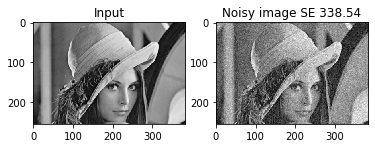

In [5]:
plt.figure(1)

plt.subplot(121)
plt.imshow(im, cmap='gray')
plt.title('Input')

plt.subplot(122)
plt.imshow(noise1, cmap='gray')
plt.title('Noisy image SE {:.2f}'.format(error1))

plt.show(block=False)

In [121]:
class EncDec(nn.Module):

    def __init__(self):
        super(EncDec, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 2, 1) # Encoder - 1
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 32, 3, 2, 1) # Encoder - 2
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, 3, 2, 1) # Encoder - 3
        self.bn3 = nn.BatchNorm2d(64)
        
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv4 = nn.Conv2d(64, 64, 3, 1, 1) # Decoder - 1
        self.bn4 = nn.BatchNorm2d(64)
        
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv5 = nn.Conv2d(64, 32, 3, 1, 1) # Decoder - 2 
        self.bn5 = nn.BatchNorm2d(32)
        
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv6 = nn.Conv2d(32, 16, 3, 1, 1) # Decoder - 3
        self.bn6 = nn.BatchNorm2d(16)
        
        self.conv7 = nn.Conv2d(16, 1, 3, 1, 1) # Channe-1
        
    def forward(self, x):
        out = self.bn1(F.relu(self.conv1(x)))
        out = self.bn2(F.relu(self.conv2(out)))
        out = self.bn3(F.relu(self.conv3(out)))
        
        out = self.bn4(F.relu(self.conv4(self.upsample1(out))))
        out = self.bn5(F.relu(self.conv5(self.upsample2(out))))
        out = self.bn6(F.relu(self.conv6(self.upsample3(out))))
        out = F.relu(self.conv7(out))
        return out

In [176]:
net = EncDec()
noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
# Creates \eta (noisy input)
eta = torch.randn(*noisy_img.size())
out = net(eta)
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
error2 = ((im - out_img)**2).sum()
print (error2)

17651.461502149912


In [177]:
MAX_EPOCHS = 500

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

for itr in range(MAX_EPOCHS):

    # zero the parameter gradients
    optimizer.zero_grad()
    eta = torch.randn(*noisy_img.size())

    # Forward + Backward + Optimize 
    loss = criterion(net(eta), clean_img)
    loss.backward()
    optimizer.step()
    if itr % 100 == 0:
        print ("Loss = {}".format(loss.detach().numpy().reshape(-1)[0]))

Loss = 0.1780446320772171
Loss = 0.10286778956651688
Loss = 0.08310376852750778
Loss = 0.047692328691482544
Loss = 0.039271946996450424


3713.5849000608823


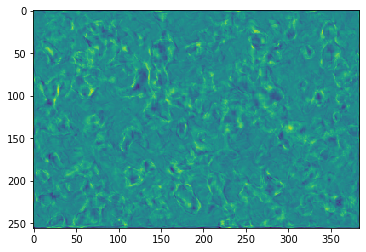

In [174]:
eta = torch.randn(*noisy_img.size())
out = net(eta)
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
error2 = ((im - out_img)**2).sum()
print (error2)
plt.imshow(out_img)

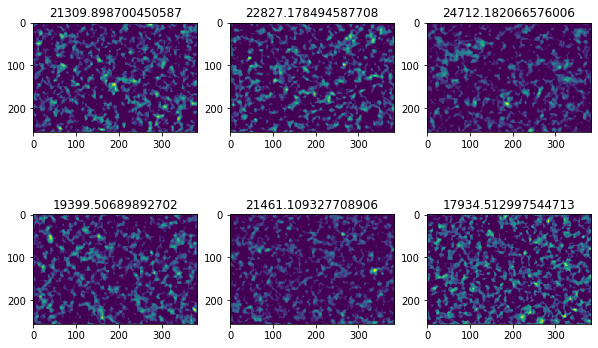

In [122]:
plt.figure(figsize=(10, 10))
for i in range(6):
    net = EncDec()
    noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
    clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
    # Creates \eta (noisy input)
    eta = torch.randn(*noisy_img.size())
    out = net(eta)
    out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
    error2 = ((im - out_img)**2).sum()

    plt.subplot(3, 3, (i+1))
    plt.title (error2)
    
    plt.imshow(out_img)

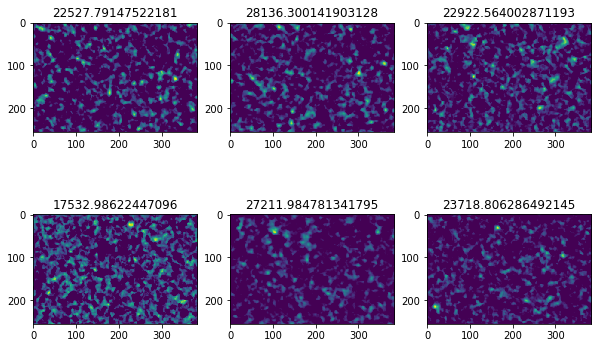

In [118]:
plt.figure(figsize=(10, 10))
for i in range(6):
    net = EncDec()
    noisy_img = torch.FloatTensor(noise1).unsqueeze(0).unsqueeze(0).transpose(2, 3)
    clean_img = torch.FloatTensor(im).unsqueeze(0).unsqueeze(0).transpose(2,3)
    # Creates \eta (noisy input)
    eta = torch.randn(*noisy_img.size())
    out = net(eta)
    out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()
    error2 = ((im - out_img)**2).sum()

    plt.subplot(3, 3, (i+1))
    plt.title (error2)
    
    plt.imshow(out_img)

In [102]:
out_img = out[0, 0, :, :].transpose(0,1).detach().numpy()